# Artificial Intelligence II (Deep Learning for Natural Language Processing)
# Homework 2

Name: Maria Miliou \
ID: 1115201300101 

## Import and install usefull packages

### Pandas, Numpy, Pytorch, sklearn, matplotlib

In [1]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import string

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.linalg.decomp import empty
from sklearn.metrics import f1_score, classification_report, recall_score,precision_score,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score

### NLTK (Natural Language Toolkit)
To tokenize, lemmatize and remove stop words

In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### GloVE 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!ls -l
!unzip glove*.zip

## Loading and Exploring Dataset


In [4]:
# Data file located at git
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading train set

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/imdb-reviews.csv", sep='\t')

print(train_df.describe())
train_df.head()

             rating
count  45008.000000
mean       5.481914
std        3.494293
min        1.000000
25%        2.000000
50%        7.000000
75%        9.000000
max       10.000000


,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


### Loading test set

In [6]:
test_df = pd.read_csv("/content/drive/MyDrive/imdb-reviews-test.csv", sep='\t') 

print(test_df.describe())
test_df.head()

            rating
count  5401.000000
mean      5.447695
std       3.495698
min       1.000000
25%       2.000000
50%       4.000000
75%       9.000000
max      10.000000


,review,rating
0,I saw this film at the 2002 Toronto Internatio...,9.0
1,The Stock Market Crash of 1929 and the Depress...,10.0
2,"Basically this is an overlong, unfunny, action...",1.0
3,And I am afraid that I cannot imagine why. It ...,1.0
4,Bubbling just beneath the surface of Showtime ...,4.0


### Find sentiment

In [7]:
#Train set
train_df['sentiment'] = train_df['rating'].apply(lambda x:0 if x<=4.0 else 1)
train_df.head()


,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...,1


In [8]:
# Test set
if not(test_df.empty):
  test_df['sentiment'] = test_df['rating'].apply(lambda x:0 if x<=4.0 else 1)
  print(test_df.head())

                                              review  rating  sentiment
0  I saw this film at the 2002 Toronto Internatio...     9.0          1
1  The Stock Market Crash of 1929 and the Depress...    10.0          1
2  Basically this is an overlong, unfunny, action...     1.0          0
3  And I am afraid that I cannot imagine why. It ...     1.0          0
4  Bubbling just beneath the surface of Showtime ...     4.0          0


##Data Pre-processing


### Cleaning data from urls, email and punctation and covert to lower case

In [9]:
def clean_data(df):
  df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
  df['review'] = df['review'].replace(r'\S*@\S*\s?', '', regex=True)
  df['review'] = df['review'].replace(r'\S*@\S*\s?', '', regex=True)
  df['review'] = df['review'].str.lower()
  df['review'] = df['review'].apply(lambda x:''.join([i for i in x  if i not in string.punctuation]))

clean_data(train_df)
if not(test_df.empty):
  clean_data(test_df)

train_df.head()


,url,rating,review,sentiment
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,i thought this was a quiet good movie it was f...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,wagon master is a very unique film amongst joh...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,this film has to be as near to perfect a film ...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,i gave this 4 stars because it has a lot of in...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,this movie is really genuine and random its re...,1


In [10]:
test_df.head()

,review,rating,sentiment
0,i saw this film at the 2002 toronto internatio...,9.0,1
1,the stock market crash of 1929 and the depress...,10.0,1
2,basically this is an overlong unfunny actionco...,1.0,0
3,and i am afraid that i cannot imagine why it r...,1.0,0
4,bubbling just beneath the surface of showtime ...,4.0,0


### Tokenization, lemmatization and remove stopwords

In [11]:
# Define stop words
def stopwrds():
  mywords=frozenset(['not', 'no', 'didnt','cannot', 'couldnt', 'never'])
  stopw = ENGLISH_STOP_WORDS.union(['br'])
  stopw = stopw.difference(mywords)
  return list(stopw)

In [12]:
def process_data(data):
  tokenizer = RegexpTokenizer(r'\w+')
  wnl = WordNetLemmatizer()


  # Tokenize
  print("\nTokenization")
  reviews=[]
  for i in range(len(data)):
    reviews.append(tokenizer.tokenize(data.iloc[i]))
    
  # Removing stop words
  print("Removing stop words")
  reviews_stop=[]
  for i in range(len(reviews)):
    reviews_stop.append([word for word in reviews[i] if not word in stopwrds()])

  # Lemmatize
  print("Lemmatizing")
  reviews=[]
  for i in range(len(reviews_stop)):
    reviews.append([wnl.lemmatize(x) for x in reviews_stop[i]])
  return reviews

### GloVe

Transform GLOVe embeddings to Word2Vec format

In [13]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

Create a map with words as keys and vectors as values 


In [14]:
with open(w2v_output_file, 'r', encoding='UTF-8') as f:
  words = set()
  word_to_vec_map = {}
  for line in f:
    w_line = line.split()
    curr_word = w_line[0]
    word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float32)

Find the mean word vector for each review. 

In [15]:
# Embeddings
embed_vector_len = word_to_vec_map['moon'].shape[0]

def get_embeddings(reviews):
  embeddings=np.zeros((len(reviews), embed_vector_len), dtype=np.float32)
  for i in range(len(reviews)):
    z=np.zeros(embed_vector_len)
    exist=0
    for word in reviews[i]:
      if word in word_to_vec_map.keys():
        z= z + word_to_vec_map.get(word)
        exist += 1
    if exist!=0:
      embeddings[i]= z/exist
    else:
      embeddings[i]= z

  print("Matrix shape: ", embeddings.shape)
  return embeddings


### Split data to validation and train sets

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_df['review'], train_df['sentiment'], test_size=0.2)


### Perform cleaning and create word vectors

In [17]:
#Train set
X_train=process_data(X_train)
X_train=get_embeddings(X_train)

#Validation set
X_val=process_data(X_val)
X_val=get_embeddings(X_val)

#Test set
if not (test_df.empty):
  X_test=process_data(test_df['review'])
  X_test=get_embeddings(X_test)



Tokenization
Removing stop words
Lemmatizing
Matrix shape:  (36006, 300)

Tokenization
Removing stop words
Lemmatizing
Matrix shape:  (9002, 300)

Tokenization
Removing stop words
Lemmatizing
Matrix shape:  (5401, 300)


### Convert to tensor

In [18]:
#x = torch.tensor(np.asarray(X_train), dtype=torch.float32)
# Train
X = torch.from_numpy(X_train)
y = torch.tensor(y_train.to_numpy())

print(f"X train shape: {X.shape}")
print(f"y train shape: {y.shape}")

# Validation
#x_test = torch.tensor(np.asarray(X_val), dtype=torch.float)
Xval = torch.from_numpy(X_val)
yval = torch.tensor(y_val.to_numpy())#y_val.to_numpy().reshape(y_val.shape[0], 1), dtype=torch.float32

print(f"X val shape: {Xval.shape}")
print(f"y val shape: {yval.shape}")

# Test
Xtest = torch.from_numpy(X_test)
ytest = torch.tensor(test_df['sentiment'].to_numpy())

print(f"X test shape: {Xtest.shape}")
print(f"y test shape: {ytest.shape}")


X train shape: torch.Size([36006, 300])
y train shape: torch.Size([36006])
X val shape: torch.Size([9002, 300])
y val shape: torch.Size([9002])
X test shape: torch.Size([5401, 300])
y test shape: torch.Size([5401])


## Training, evaluation and testing

### Define training and evaluation procedure

In [108]:
def train(epochs, dataloader, model, loss_fn, optimizer):

  train_metrics=[[],[],[],[]]   # Loss, f1, precision, recall 
  valid_metrics=[[],[],[],[]]

  for epoch in range(epochs):

    # TRAIN
    model.train()         # Train mode
    loss_sum=0 ; f1=0; pr=0; rc=0
    for x_batch, y_batch in dataloader:
      # Predict
      y_pred = model(x_batch)

      # Compute loss and metrics
      loss = loss_fn(y_pred, y_batch)

      loss_sum +=loss.item()
      _, y_pred = torch.max(y_pred, 1)
      f1 += f1_score(y_batch, y_pred, average='weighted')
      pr += precision_score(y_batch, y_pred, average='weighted')
      rc += recall_score(y_batch, y_pred, average='weighted')

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_metrics[0].append(loss_sum/len(dataloader))
    train_metrics[1].append(f1/len(dataloader))
    train_metrics[2].append(pr/len(dataloader))
    train_metrics[3].append(rc/len(dataloader))

    # VALIDATION
    with torch.no_grad():
      model.eval()        # Evaluation mode
      # Predict
      y_pred_val = model(Xval)

      # Loss and metrics
      val_loss = loss_fn(y_pred_val, yval)
      valid_metrics[0].append(val_loss.item())

      _, y_pred_val = torch.max(y_pred_val, 1)
      valid_metrics[1].append(f1_score(yval, y_pred_val, average='weighted'))
      valid_metrics[2].append(precision_score(yval, y_pred_val, average='weighted'))
      valid_metrics[3].append(recall_score(yval, y_pred_val, average='weighted'))

      print(f"Epoch {epoch} TRAIN Loss: {train_metrics[0][-1]} F1-score: {train_metrics[1][-1]} Precision: {train_metrics[2][-1]} Recall: {train_metrics[3][-1]}")
      print(f"\tTEST Loss: {valid_metrics[0][-1]} F1-score: {valid_metrics[1][-1]} Precision: {valid_metrics[2][-1]} Recall: {valid_metrics[3][-1]}")

  return train_metrics, valid_metrics


### Define testing procedure

In [58]:
from nltk.metrics.scores import accuracy
def test(model, Xtest, ytest):
   with torch.no_grad():
      model.eval()        # Evaluation mode
      #Predict
      y_pred = model(Xtest)
      _, y_pred = torch.max(y_pred, 1)

      # Calculate metrics
      print("F1 score: ", f1_score(ytest, y_pred, average='weighted'))
      print("precision score: ", precision_score(ytest, y_pred, average='weighted'))
      print("recall score: ", recall_score(ytest, y_pred, average='weighted'))
      print("Accuracy: ", accuracy_score(ytest, y_pred))

      disp = ConfusionMatrixDisplay(confusion_matrix(ytest, y_pred), display_labels=['negative', 'positive'])
      disp.plot()
      plt.show()
      

### Define functions for plotting

In [277]:
def plot_metric(metric, figure, list_x, valid_metric, train_metric):
  plt.subplot(1, 4, figure)
  plt.plot(list_x, valid_metric, label = "Validation")
  plt.plot(list_x, train_metric, label = "Training")
  plt.legend()
  plt.ylabel(metric)
  plt.xlabel("epochs")

def plot_metrics(epochs, valid_metric, train_metric):
  plt.figure(figsize=(20, 5))

  list_x = [x for x in range(epochs)] 

  plot_metric("Loss", 1, list_x, valid_metric[0], train_metric[0])
  plot_metric("F1-score", 2, list_x, valid_metric[1], train_metric[1])
  plot_metric("Precision", 3, list_x, valid_metric[2], train_metric[2])
  plot_metric("Recall", 4, list_x, valid_metric[3], train_metric[3])

def plot_roc(model, Xtrain, ytrain, Xval, yval):
  #Train
  y_pred = model(Xtrain)
  _, y_pred = torch.max(y_pred, 1)
  fpr1, tpr1, thresholds = roc_curve(ytrain, y_pred)
  roc_auc1 = auc(fpr1, tpr1)
  #Validation
  y_pred = model(Xval)
  _, y_pred = torch.max(y_pred, 1)
  fpr2, tpr2, thresholds = roc_curve(yval, y_pred)
  roc_auc2 = auc(fpr2, tpr2)

  plt.figure()
  plt.plot(fpr1,tpr1, label="Train (AUC = {0:0.4f})".format(roc_auc1))
  plt.plot(fpr2,tpr2, label="Validation (AUC = {0:0.4f})".format(roc_auc2))
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()


## Create various models and trying different parameters

### Model 1
**My best model**

Network

In [351]:
class Model_1(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super(Model_1, self).__init__()

    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
    
    self.dropout = nn.Dropout(p=0.7)
    self.activation = nn.ReLU()
  def forward(self, x):
    h1 = self.dropout(self.activation(self.linear1(x)))
    h2 = self.dropout(self.activation(self.linear2(h1)))
    out = self.linear3(h2)

    return out

Parameters

In [352]:
#Define layer sizes
D_in = embed_vector_len
H1 = 256
H2 = 128
D_out = 2

#Define Hyperparameters
learning_rate = 1e-3

#Define batch_size
batch_size=1024

#Initialise model, loss, optimizer
model = Model_1(D_in, H1, H2, D_out)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#Initialise dataloader

train_dataset = torch.utils.data.TensorDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

Training

In [353]:
train_scores, valid_scores = train(30, train_dataloader, model, loss_func, optimizer)

Epoch 0 TRAIN Loss: 0.6141745497783025 F1-score: 0.66081761057332 Precision: 0.6711155137384585 Recall: 0.6668679928045516
	TEST Loss: 0.472210168838501 F1-score: 0.7799365160922677 Precision: 0.7820269184942527 Recall: 0.7802710508775828
Epoch 1 TRAIN Loss: 0.4574744916624493 F1-score: 0.7919004087575128 Precision: 0.7927956290465165 Recall: 0.7920627823795181
	TEST Loss: 0.40059566497802734 F1-score: 0.8228672973585435 Precision: 0.8233940026157397 Recall: 0.8229282381692957
Epoch 2 TRAIN Loss: 0.4159342323740323 F1-score: 0.8156772044736216 Precision: 0.8162085878519262 Recall: 0.8157489985985609
	TEST Loss: 0.38545089960098267 F1-score: 0.8288082669876216 Precision: 0.8298708006397099 Recall: 0.8289269051321928
Epoch 3 TRAIN Loss: 0.40736855649285847 F1-score: 0.8216682250914592 Precision: 0.8222380924692461 Recall: 0.8217440072791165
	TEST Loss: 0.3796629309654236 F1-score: 0.8324197977908722 Precision: 0.8329951595400478 Recall: 0.8324816707398356
Epoch 4 TRAIN Loss: 0.3996478319

Plots

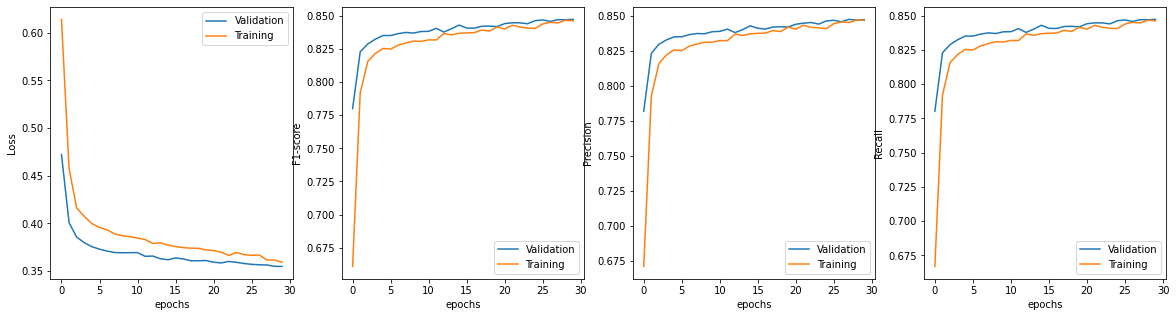

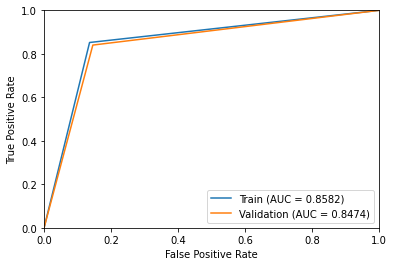

In [355]:
plot_metrics(30, valid_scores, train_scores)
plot_roc(model, X, y, Xval, yval)

Testing

F1 score:  0.8473602598138676
precision score:  0.8474389427451541
recall score:  0.8473672517218396
Accuracy:  0.8473672517218396


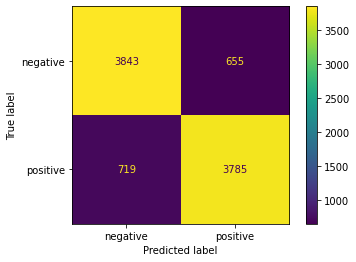

In [358]:
test(model, Xval, yval)

F1 score:  0.8594729254185509
precision score:  0.8594924122159503
recall score:  0.8594704684317719
Accuracy:  0.8594704684317719


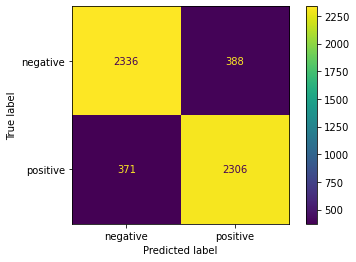

In [278]:
# Here you can see scores for test set you provided
test(model, Xtest, ytest)

### Model 2 
*Changing number of layers and removing Dropout* 

Network

In [281]:
class Model_2(nn.Module):
  def __init__(self, D_in, H1, D_out):
    super(Model_2, self).__init__()

    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, D_out)
    
    self.dropout = nn.Dropout(p=0.7)
    self.activation = nn.ReLU()

  def forward(self, x):
    h1 = self.dropout(self.activation(self.linear1(x)))
    out = self.linear2(h1)

    return out

Parameters

In [290]:
#Initialise model, optimizer
model = Model_2(D_in, H1, D_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Training

In [291]:
train_scores, valid_scores = train(30, train_dataloader, model, loss_func, optimizer)

Epoch 0 TRAIN Loss: 0.600871205329895 F1-score: 0.6995444423935395 Precision: 0.7077119808119715 Recall: 0.7049585058985943
	TEST Loss: 0.4986576735973358 F1-score: 0.7729292303571464 Precision: 0.7736588769170444 Recall: 0.7730504332370585
Epoch 1 TRAIN Loss: 0.4673772114846442 F1-score: 0.7843075312101099 Precision: 0.7849606719278635 Recall: 0.7844310183442101
	TEST Loss: 0.42273783683776855 F1-score: 0.8111491805829708 Precision: 0.8111840446726656 Recall: 0.8111530770939791
Epoch 2 TRAIN Loss: 0.42333195358514786 F1-score: 0.8093960419743857 Precision: 0.8097607836338153 Recall: 0.8094647470088687
	TEST Loss: 0.39743104577064514 F1-score: 0.8250214097100048 Precision: 0.8251801122576061 Recall: 0.8250388802488335
Epoch 3 TRAIN Loss: 0.40531709293524426 F1-score: 0.8188400295232685 Precision: 0.8192413661722239 Recall: 0.8189002755814926
	TEST Loss: 0.3863345682621002 F1-score: 0.8302441054894466 Precision: 0.8303942999114791 Recall: 0.8302599422350588
Epoch 4 TRAIN Loss: 0.3969813

Plots

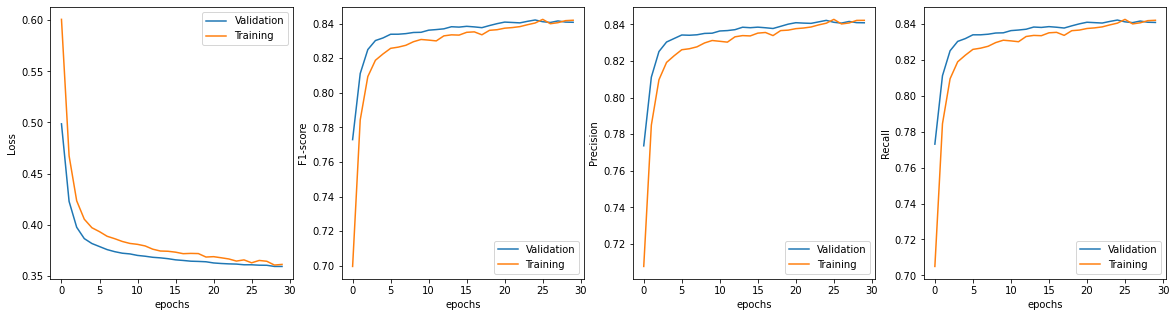

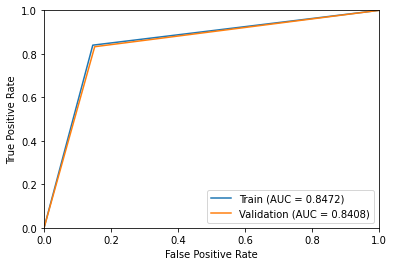

In [292]:
plot_metrics(30, valid_scores, train_scores)
plot_roc(model,X, y, Xval, yval)

Testing

F1 score:  0.8408035442369225
precision score:  0.8409045442580766
recall score:  0.8408131526327483
Accuracy:  0.8408131526327483


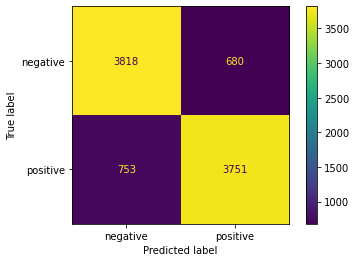

In [294]:
test(model, Xval, yval)

F1 score:  0.8487116424792013
precision score:  0.8487992149188431
recall score:  0.8487317163488243
Accuracy:  0.8487317163488243


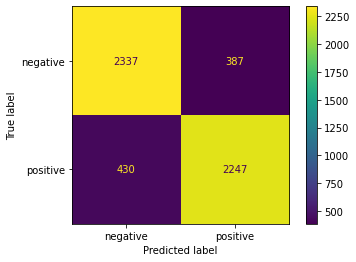

In [293]:
# Here you can see scores for test set you provided
test(model, Xtest, ytest)

### Model 3
*Without activation function and dropout*

Network

In [314]:
class Model_3(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super(Model_3, self).__init__()

    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)

  def forward(self, x):
    h1 = self.linear1(x)
    h2 = self.linear2(h1)
    out = self.linear3(h2)

    return out

Parameters

In [315]:
H1 = 256
H2 = 128

#Initialise model, loss, optimizer
model = Model_3(D_in, H1, H2, D_out)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Training

In [316]:
train_scores, valid_scores = train(30, train_dataloader, model, loss_func, optimizer)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0 TRAIN Loss: 0.5403529910577668 F1-score: 0.7085717293766631 Precision: 0.7468932098870767 Recall: 0.7277586910140562
	TEST Loss: 0.4210592806339264 F1-score: 0.807055460403767 Precision: 0.8093894131074574 Recall: 0.8073761386358587
Epoch 1 TRAIN Loss: 0.4054506967465083 F1-score: 0.816907657700832 Precision: 0.8187088148517474 Recall: 0.8171416133283133
	TEST Loss: 0.39148837327957153 F1-score: 0.8253571306308817 Precision: 0.8282750845439858 Recall: 0.8257053988002666
Epoch 2 TRAIN Loss: 0.38932394484678906 F1-score: 0.8259268183609949 Precision: 0.8271775204955967 Recall: 0.8260754606969545
	TEST Loss: 0.3857818841934204 F1-score: 0.8271516755001657 Precision: 0.829963089767123 Recall: 0.827482781604088
Epoch 3 TRAIN Loss: 0.3871977917022175 F1-score: 0.8277105313982046 Precision: 0.829200455719578 Recall: 0.8279017763763387
	TEST Loss: 0.3831465542316437 F1-score: 0.830306536963449 Precision: 0.8327967860585892 Recall: 0.8305932015107754
Epoch 4 TRAIN Loss: 0.38330768711037

Plots

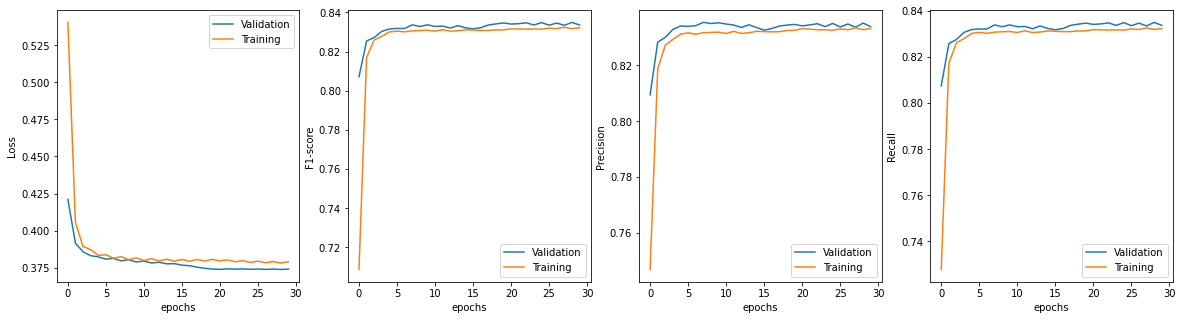

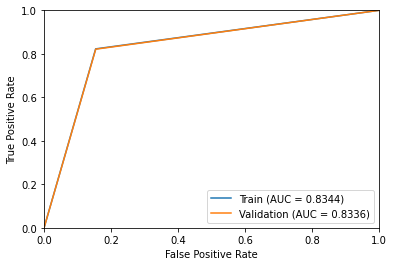

In [317]:
plot_metrics(30, valid_scores, train_scores)
plot_roc(model, X, y, Xval, yval)

Testing

F1 score:  0.833569039811939
precision score:  0.8337946030810901
recall score:  0.833592534992224
Accuracy:  0.833592534992224


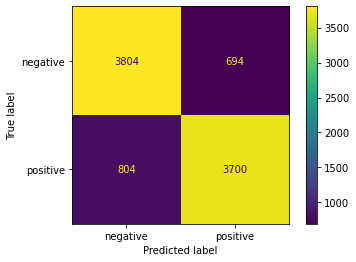

In [318]:
test(model, Xval, yval)

F1 score:  0.8384850726689345
precision score:  0.8388475101035554
recall score:  0.8385484169598223
Accuracy:  0.8385484169598223


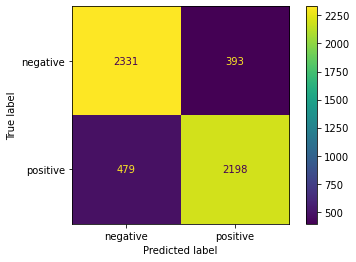

In [319]:
# Here you can see scores for test set you provided
test(model, Xtest, ytest)

### Trying different hyperparameters on Model 1

#### Changing learning rate

Parameters

In [329]:
#Define Hyperparameters
learning_rate = 1e-4

#Define batch_size
batch_size=1024

#Initialise model, optimizer
model = Model_1(D_in, H1, H2, D_out)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#Initialise dataloader

train_dataset = torch.utils.data.TensorDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

Training

In [330]:
train_scores, valid_scores = train(60, train_dataloader, model, loss_func, optimizer)

Epoch 0 TRAIN Loss: 0.6920314017269347 F1-score: 0.4959515596485258 Precision: 0.5289471535810127 Recall: 0.5230309257864793
	TEST Loss: 0.6872429251670837 F1-score: 0.5949896661915322 Precision: 0.7276898238087289 Recall: 0.6357476116418573
Epoch 1 TRAIN Loss: 0.6834736896885766 F1-score: 0.5857880991008018 Precision: 0.5888194655661878 Recall: 0.5870379303673026
	TEST Loss: 0.6718040704727173 F1-score: 0.7530460177612467 Precision: 0.7530975504343522 Recall: 0.753054876694068
Epoch 2 TRAIN Loss: 0.6641632715861002 F1-score: 0.6548649270675615 Precision: 0.6572294220903347 Recall: 0.6554375052292504
	TEST Loss: 0.6359542608261108 F1-score: 0.7540473295970416 Precision: 0.7552606302524703 Recall: 0.7542768273716952
Epoch 3 TRAIN Loss: 0.6248313089211782 F1-score: 0.7065503116051327 Precision: 0.7093865413536524 Recall: 0.7072368249037818
	TEST Loss: 0.5788625478744507 F1-score: 0.7597318832584353 Precision: 0.7602822191745059 Recall: 0.759831148633637
Epoch 4 TRAIN Loss: 0.574406160248

Plots

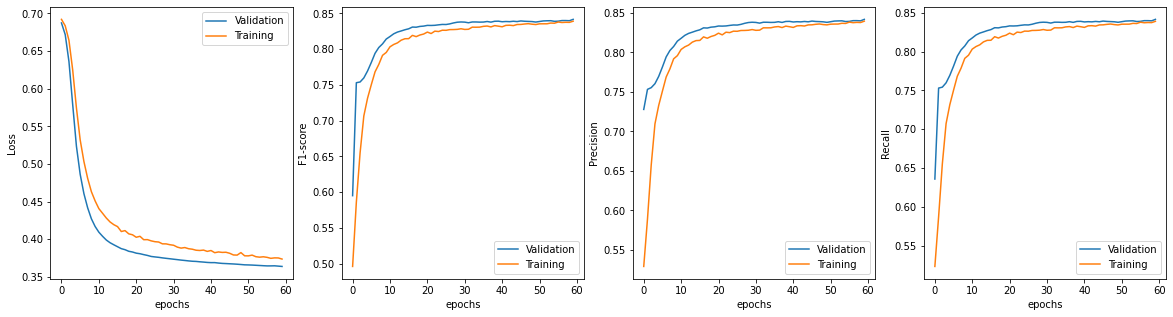

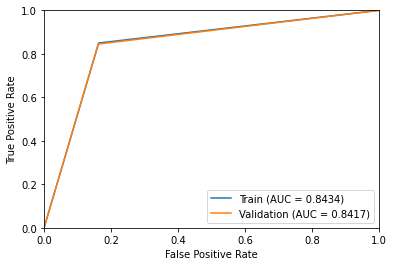

In [331]:
plot_metrics(60, valid_scores, train_scores)
plot_roc(model, X, y, Xval, yval)

Testing

F1 score:  0.8429915109959858
precision score:  0.8429912146818689
recall score:  0.8429920385113868
Accuracy:  0.8429920385113868


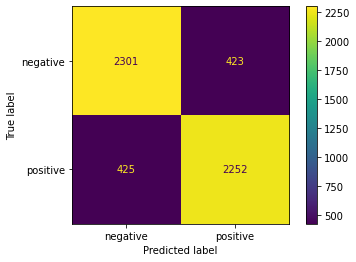

In [332]:
# Here you can see scores for test set you provided
test(model, Xtest, ytest)

#### Trying different optimizers

Parameters

In [347]:
#Define Hyperparameters
learning_rate = 1e-3


#Initialise model, loss, optimizer
model = Model_1(D_in, H1, H2, D_out)

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

Training

In [348]:
train_scores, valid_scores = train(55, train_dataloader, model, loss_func, optimizer)

Epoch 0 TRAIN Loss: 0.6693282839324739 F1-score: 0.6042932384233373 Precision: 0.6214856732246494 Recall: 0.6164024587935074
	TEST Loss: 0.6226182579994202 F1-score: 0.7479536025399888 Precision: 0.7490401511632584 Recall: 0.7481670739835592
Epoch 1 TRAIN Loss: 0.6028736117813323 F1-score: 0.7148824875817164 Precision: 0.7160478559165316 Recall: 0.7151983585383199
	TEST Loss: 0.5487799048423767 F1-score: 0.7640518038762341 Precision: 0.7640538904048558 Recall: 0.7640524327927127
Epoch 2 TRAIN Loss: 0.5524996502531899 F1-score: 0.7424359624381301 Precision: 0.7430402782692132 Recall: 0.7425424353664659
	TEST Loss: 0.5058119893074036 F1-score: 0.7760426032372799 Precision: 0.7760795730922421 Recall: 0.776049766718507
Epoch 3 TRAIN Loss: 0.5192951237161955 F1-score: 0.7587989209593027 Precision: 0.7593037390505981 Recall: 0.7588684817394579
	TEST Loss: 0.47880879044532776 F1-score: 0.7853804543745683 Precision: 0.7853861626263201 Recall: 0.7853810264385692
Epoch 4 TRAIN Loss: 0.5007646398

Plots

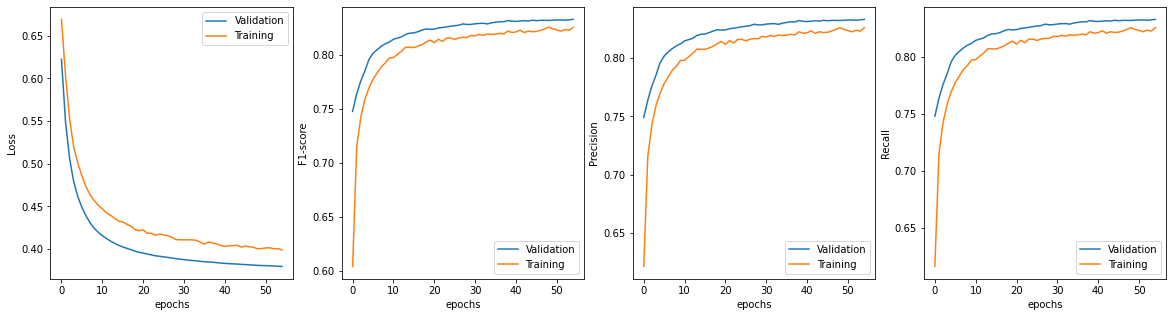

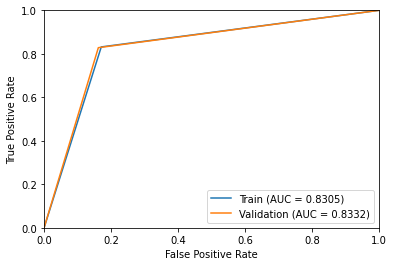

In [349]:
plot_metrics(55, valid_scores, train_scores)
plot_roc(model, X, y, Xval, yval)

Testing

F1 score:  0.8316825988006803
precision score:  0.831729482044777
recall score:  0.8316978337344936
Accuracy:  0.8316978337344936


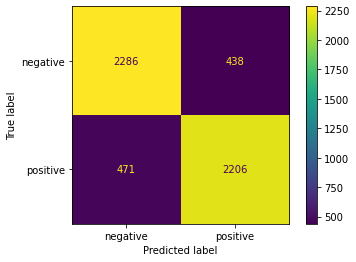

In [350]:
# Here you can see scores for test set you provided
test(model, Xtest, ytest)